In [1]:
import sys
sys.path.append('F:\Cambridge\Project\MHMC-for-VAE\change_of_variable')
sys.path.append('F:\Cambridge\Project\MHMC-for-VAE\hmc_pytorch')
from change_of_variable_pytorch import * 
from hmc_base_pytorch import *
from hmc_unconstrained_pytorch import *
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt

import torch.utils.data
from torch import optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import time

In [3]:
math.pi

3.141592653589793

In [2]:
cuda = True
batch_size = 128
epochs = 10
seed = 1
log_interval = 10
z_dim = 20

device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [3]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

In [4]:
def log_prior(z):
    dim = z.shape[1]
    mean = torch.zeros(dim).cuda()
    cov = torch.eye(dim).cuda()
    m = MultivariateNormal(mean, cov)
    m.requires_grad=True
    return m.log_prob(z)

In [5]:
def multivariate_normal_logpdf(mean, cov, x):
    mean = mean.cuda()
    cov = cov.cuda()
    k = x.shape[0]
    #cov = cov + (1e-6*torch.eye(k)).cuda()
    t1 = -0.5*(x - mean).view(1, k)@torch.inverse(cov)@(x - mean).view(k, 1)
    #t21 = 0.5*k*torch.log(2*torch.tensor([math.pi]).cuda())
    #t22 = 0.5*torch.log(torch.det(cov))
    #t2 = t21 + t22
    t2 = 0.5*k*torch.log(2*torch.tensor([math.pi]).cuda()) + 0.5*torch.log(torch.det(cov))
    return t1 - t2

In [6]:
torch.eye(4)

tensor([[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.]])

In [10]:
start_time = time.time()
mean = torch.tensor([0., 0.]).cuda()
cov = torch.eye(2).cuda()
x = torch.tensor([0., 1.]).cuda()
print(multivariate_normal_logpdf(mean, cov, x))
print("--- %s seconds ---" % (time.time() - start_time))

tensor([[-2.3379]], device='cuda:0')
--- 0.009974956512451172 seconds ---


In [11]:
start_time = time.time()
mean = torch.tensor([0., 0.]).cuda()
cov = torch.eye(2).cuda()
x = torch.tensor([0., 1.]).cuda()
m = MultivariateNormal(mean, cov)
print(m.log_prob(x))
print("--- %s seconds ---" % (time.time() - start_time))

tensor(-2.3379, device='cuda:0')
--- 0.013963699340820312 seconds ---


In [11]:
m = MultivariateNormal(mean, cov)
m.log_prob(x)

tensor(-2.3379, device='cuda:0')

In [11]:
z = torch.tensor([[1.,1.],[2.,2.],[3.,3.]])
print(z.shape)


torch.Size([3, 2])


In [12]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, 400)
        self.fc2 = nn.Linear(400, 784)
    # single hidden layer
    def forward(self, x):
        #x = x.view(-1, 784)
        h1 = F.relu(self.fc1(x))
        return F.sigmoid(self.fc2(h1))

In [13]:
class q_z0(nn.Module):
    def __init__(self):
        super(q_z0, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc31 = nn.Linear(300, z_dim)
        self.fc32 = nn.Linear(300, z_dim)
    def forward(self, x):
        x = x.view(-1, 784)
        h1 = F.softplus(self.fc1(x))
        h2 = F.softplus(self.fc2(h1))
        logvar = self.fc31(h2)
        mu = self.fc32(h2)
        return mu, logvar
    

In [14]:
class r_v(nn.Module):
    def __init__(self):
        super(r_v, self).__init__()
        self.fc1 = nn.Linear(z_dim + 784, 300)
        self.fc21 = nn.Linear(300, z_dim)
        self.fc22 = nn.Linear(300, z_dim)
    def forward(self, x):
        x = x.view(-1, 784 + z_dim)
        h1 = F.softplus(self.fc1(x))
        logvar = self.fc21(h1)
        mu = self.fc22(h1)
        return mu, logvar

In [15]:
class q_v(nn.Module):
    def __init__(self):
        super(q_v, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        # no need to output mu because the mean of momentum is default 0
        self.fc21 = nn.Linear(300, z_dim)
    def forward(self, x):
        x = x.view(-1, 784)
        h1 = F.softplus(self.fc1(x))
        logvar = self.fc21(h1)
        return logvar

In [16]:
mean = torch.zeros(2,1)
cov = torch.eye(2)
m = MultivariateNormal(mean, cov)
x = torch.tensor([0.,0.]) 
m.log_prob(x)

tensor([-0.9189, -0.9189])

In [16]:
decoder = decoder().to(device)
q_z0 = q_z0().to(device)
r_v = r_v().to(device)
q_v = q_v().to(device)
mass_diag = torch.randn(z_dim, requires_grad=True)
#mass = torch.randn(z_dim, requires_grad=True)
#mass = torch.eye(z_dim, requires_grad=True)
#mass_cuda = mass.cuda()

In [11]:
#mass = Variable(torch.randn(batch_size, 100).cuda(), requires_grad=True)
#mass_diag = torch.randn(z_dim, requires_grad=True)
#mass_matrix = torch.diag(mass_diag).cuda()

In [17]:
def lower_bound(decoder, q_z0, r_v, q_v, data, mass_diag, T):
    data = data.to(device)
    mu_z0, logvar_z0 = q_z0(data)
    var_z0 = torch.exp(logvar_z0)
    #print(logvar_z0.shape)

    # sample z0
    z0 = reparameterize(mu_z0, logvar_z0)
    #print("z0: " + str(z0.shape))

    # get joint probaility p(x, z0)
    log_prior_z0 = log_prior(z0)
    #print("log_prior_z0: " + str(log_prior_z0.shape))
    decoder_output = decoder(z0)
    #print("decoder_output: " + str(decoder_output.shape))
    log_likelihood = 0. - F.binary_cross_entropy(decoder_output, data.view(-1, 784), size_average=False, reduce=False)
    #print("log_likelihood: " + str(log_likelihood.shape))
    log_likelihood = torch.sum(log_likelihood, dim = 1)
    #print("log_likelihood: " + str(log_likelihood.shape))
    log_joint = log_prior_z0 + log_likelihood
    #print("log_joint: " + str(log_joint.shape))

    # get log q_z0
    log_q_z0 = torch.zeros(0).cuda()
    for i in range(batch_size):
        one_cov = torch.diag(var_z0[i])
        #m = MultivariateNormal(mu_z0[i], one_cov)
        #one_q_z0 = m.log_prob(z0[i]).view(1)
        one_q_z0 = multivariate_normal_logpdf(mu_z0[i], one_cov, z0[i])
        #print("one q z0: " + str(one_q_z0))
        log_q_z0 = torch.cat((log_q_z0,one_q_z0),0)
    #print("log_q_z0: " + str(log_q_z0.shape))


    # initial L for 128 samples
    L = log_joint - log_q_z0
    L = torch.sum(L)
    #print("L "+str(L))
    #print(L.shape)

    #print("====================================")
    for i in range(T):
         # sample v_t'(v1)
        logvar_v1 = q_v(data)
        var_v1 = torch.exp(logvar_v1)
        #print("logvar_v1: " + str(logvar_v1.shape))
        mu_v1 = torch.zeros(logvar_v1.shape[0], logvar_v1.shape[1]).cuda()
        v1 = reparameterize(mu_v1, logvar_v1)
        #print("v1: "+str(v1.shape))

        # get q_v1
        log_q_v1 = torch.zeros(0).cuda()
        for i in range(batch_size):
            one_cov = torch.diag(var_v1[i])
            #m = MultivariateNormal(mu_v1[i], one_cov)
            #one_q_v1 = m.log_prob(v1[i]).view(1)
            one_q_v1 = multivariate_normal_logpdf(mu_v1[i], one_cov, v1[i])
            log_q_v1 = torch.cat((log_q_v1,one_q_v1),0)
        #print("log_q_v1: "+str(log_q_v1.shape))

        log_joint_t = torch.zeros(0).cuda() # list of all the joint
        log_r_vt = torch.zeros(0).cuda()
        alpha = torch.tensor([0.]).cuda() # lower bound for each batch (128 samples)
        for j in range(batch_size):
            def energy_function(z, cache):
                z.retain_grad()
                z = z.view(1, z.shape[0])
                z = z.cuda()
                one_log_prior = log_prior(z)
                decoder_output = decoder(z)
                one_log_likelihood = 0. - F.binary_cross_entropy(decoder_output, data.view(-1, 784)[j], size_average=False, reduce=False)
                #print(one_log_likelihood.shape)
                one_log_likelihood = torch.sum(one_log_likelihood, dim = 1)
                one_log_joint = one_log_prior + one_log_likelihood
                return 0 - one_log_joint
            sampler = IsotropicHmcSampler(energy_function, energy_grad=None, prng=None,
                                          mom_resample_coeff=1., dtype=np.float64)
            init = torch.zeros(z_dim).cuda()
            mass_matrix = torch.diag(mass_diag)
            mass_matrix.cuda()
            pos_samples, mom_samples, ratio = sampler.get_samples(init, 0.1, 3, 2, mass_matrix, mom = v1[j].view(z_dim))
            #print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")
            #print(pos_samples[1].shape)

            # get joint probaility p(x, zt)
            zt = pos_samples[1].cuda()
            vt = mom_samples[1].cuda()
            zt = zt.view(1, zt.shape[0])
            vt = vt.view(vt.shape[0])

            # get joint probaility p(x, zt)
            one_log_prior_zt = log_prior(zt)
            #print("one_log_prior_zt: " + str(one_log_prior_zt.shape))
            one_decoder_output_t = decoder(zt)
            #print("one_decoder_output_t: " + str(one_decoder_output_t.shape))
            one_log_likelihood_t = 0. - F.binary_cross_entropy(one_decoder_output_t, data.view(-1, 784)[j], size_average=False, reduce=False)
            one_log_likelihood_t = torch.sum(one_log_likelihood_t, dim = 1)
            #print("one_log_likelihood_t: " + str(one_log_likelihood_t.shape))
            one_log_joint_t = one_log_prior_zt + one_log_likelihood_t
            #print("one_log_joint_t: " + str(one_log_joint_t.shape))
            log_joint_t = torch.cat((log_joint_t, one_log_joint_t), 0)

            # get r_vt
            d = data.view(-1, 784)[j].view(1, 784)
            one_new_data = torch.cat((d, zt), 1) # append data with zt
            one_mu_vt, one_logvar_vt = r_v(one_new_data)
            one_var_vt = torch.exp(one_logvar_vt)
            one_mu_vt = one_mu_vt.view(one_mu_vt.shape[1])
            one_cov = torch.diag(one_var_vt.view(one_var_vt.shape[1]))
            #m = MultivariateNormal(one_mu_vt, one_cov)
            #one_log_r_vt = m.log_prob(vt).view(1)
            one_log_r_vt = multivariate_normal_logpdf(one_mu_vt, one_cov, vt)
            log_r_vt = torch.cat((log_r_vt, one_log_r_vt), 0)
            

            # get L for each sample
            one_log_alpha = log_joint_t[j] + log_r_vt[j] - log_joint[j] - log_q_v1[j]
            #print("one log alpha: "+str(one_log_alpha))
            #one_log_alpha = torch.log(one_alpha)
            L = L + one_log_alpha
            #alpha = alpha + one_alpha
        #L = L + torch.log(alpha)

    #print("~~~~~~~~~~~~~~~~~~~ new L " + str(L) + " ~~~~~~~~~~~~~~~~~~~")
    return L    
                

In [20]:
params1 = list(decoder.parameters())+list(q_z0.parameters())+list(r_v.parameters())+list(q_v.parameters())+list(mass_diag)
optimizer1 = optim.Adam(params1, lr=1e-3)
#optimizer2 = optim.Adam([mass_diag], lr=1e-3)

for batch_idx, (data, _) in enumerate(train_loader):
    print("++++++++++ " + str(batch_idx) + " ++++++++++")
    optimizer1.zero_grad()
    #optimizer2.zero_grad()
    L = lower_bound(decoder, q_z0, r_v, q_v, data, mass_diag, 1)
    loss = 0. - L
    loss.backward()
    optimizer1.step()
    #optimizer2.step()
print(L)

ValueError: can't optimize a non-leaf Tensor

In [18]:
params1 = list(decoder.parameters())+list(q_z0.parameters())+list(r_v.parameters())+list(q_v.parameters())
optimizer1 = optim.Adam(params1, lr=1e-3)
optimizer2 = optim.Adam([mass_diag], lr=1e-3)

for batch_idx, (data, _) in enumerate(train_loader):
    print("++++++++++ " + str(batch_idx) + " ++++++++++")
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    L = lower_bound(decoder, q_z0, r_v, q_v, data, mass_diag, 1)
    loss = 0. - L
    loss.backward()
    optimizer1.step()
    optimizer2.step()
print(L)

++++++++++ 0 ++++++++++


D:\Anaconda3\lib\site-packages\torch\nn\functional.py:1474: UserWarning: Using a target size (torch.Size([784])) that is different to the input size (torch.Size([1, 784])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


++++++++++ 1 ++++++++++
++++++++++ 2 ++++++++++
++++++++++ 3 ++++++++++
++++++++++ 4 ++++++++++
++++++++++ 5 ++++++++++
++++++++++ 6 ++++++++++
++++++++++ 7 ++++++++++
++++++++++ 8 ++++++++++
++++++++++ 9 ++++++++++
++++++++++ 10 ++++++++++
++++++++++ 11 ++++++++++
++++++++++ 12 ++++++++++
++++++++++ 13 ++++++++++
++++++++++ 14 ++++++++++
++++++++++ 15 ++++++++++
++++++++++ 16 ++++++++++
++++++++++ 17 ++++++++++
++++++++++ 18 ++++++++++
++++++++++ 19 ++++++++++
++++++++++ 20 ++++++++++
++++++++++ 21 ++++++++++
++++++++++ 22 ++++++++++
++++++++++ 23 ++++++++++
++++++++++ 24 ++++++++++
++++++++++ 25 ++++++++++
++++++++++ 26 ++++++++++
++++++++++ 27 ++++++++++
++++++++++ 28 ++++++++++
++++++++++ 29 ++++++++++
++++++++++ 30 ++++++++++
++++++++++ 31 ++++++++++
++++++++++ 32 ++++++++++
++++++++++ 33 ++++++++++
++++++++++ 34 ++++++++++
++++++++++ 35 ++++++++++
++++++++++ 36 ++++++++++
++++++++++ 37 ++++++++++
++++++++++ 38 ++++++++++
++++++++++ 39 ++++++++++
++++++++++ 40 ++++++++++
+++++++++

++++++++++ 321 ++++++++++
++++++++++ 322 ++++++++++
++++++++++ 323 ++++++++++
++++++++++ 324 ++++++++++
++++++++++ 325 ++++++++++
++++++++++ 326 ++++++++++
++++++++++ 327 ++++++++++
++++++++++ 328 ++++++++++
++++++++++ 329 ++++++++++
++++++++++ 330 ++++++++++
++++++++++ 331 ++++++++++
++++++++++ 332 ++++++++++
++++++++++ 333 ++++++++++
++++++++++ 334 ++++++++++
++++++++++ 335 ++++++++++
++++++++++ 336 ++++++++++
++++++++++ 337 ++++++++++
++++++++++ 338 ++++++++++
++++++++++ 339 ++++++++++
++++++++++ 340 ++++++++++
++++++++++ 341 ++++++++++
++++++++++ 342 ++++++++++
++++++++++ 343 ++++++++++
++++++++++ 344 ++++++++++
++++++++++ 345 ++++++++++
++++++++++ 346 ++++++++++
++++++++++ 347 ++++++++++
++++++++++ 348 ++++++++++
++++++++++ 349 ++++++++++
++++++++++ 350 ++++++++++
++++++++++ 351 ++++++++++
++++++++++ 352 ++++++++++
++++++++++ 353 ++++++++++
++++++++++ 354 ++++++++++
++++++++++ 355 ++++++++++
++++++++++ 356 ++++++++++
++++++++++ 357 ++++++++++
++++++++++ 358 ++++++++++
++++++++++ 3

IndexError: index 96 is out of bounds for dimension 0 with size 96

In [19]:
L

tensor(1.00000e+06 *
       [-2.2254], device='cuda:0')

In [37]:
#params = mass_diag


#optimizer = optim.Adam(params, lr=1e-3)

w = torch.randn([3,5], requires_grad=True)
b = torch.randn(3, requires_grad=True)
#x = Variable(torch.randn(5))

optimizer = optim.SGD([w], lr=0.01)

TypeError: params argument given to the optimizer should be an iterable of Tensors or dicts, but got torch.FloatTensor

In [21]:
list(decoder.parameters())
params[0].shape

torch.Size([400, 20])

In [25]:
list(decoder.parameters())[0]
#list(mass_diag)[0]
mass_diag.is_cuda

False

In [78]:
tt = torch.ones(1, 784).cuda()
print(tt.shape)
torch.sum(tt, dim=1)
tt.is_cuda

torch.Size([1, 784])


True

In [ ]:
x = torch.tensor([[0.1, 0.1],[0.1,0.1],[0.1,0.1]])
y = torch.tensor([[0.5, 0.5],[0.5,0.5],[1.,1.]])
L = F.binary_cross_entropy(y, x, size_average=False, reduce=False)
L

In [17]:
x = torch.tensor([[0.1, 0.1],[0.1,0.1]])
torch.inverse(x)

RuntimeError: Lapack Error getrf : U(2,2) is 0, U is singular at c:\programdata\miniconda3\conda-bld\pytorch_1524546354046\work\aten\src\th\generic/THTensorLapack.c:514

In [170]:
torch.sum(L, dim=1)

tensor([  1.3863,   1.3863,  49.7358])

In [34]:
torch.diag(torch.tensor([1, 2, 3]))

tensor([[ 1,  0,  0],
        [ 0,  2,  0],
        [ 0,  0,  3]])

In [53]:
torch.normal(torch.tensor([0.]),torch.tensor([1.]))

tensor([ 1.0050])

In [53]:
torch.eye(2, requires_grad=True)

tensor([[ 1.,  0.],
        [ 0.,  1.]])

In [10]:
y = x.view(1, 3)
y.view(1,3)

tensor([[ 0.3646,  0.7910,  0.5176]])

In [16]:
x = []
for i in range(500):
    x.append(reparameterize(torch.tensor([0.]), torch.tensor([1.])).item())

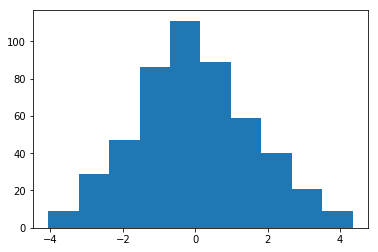

In [17]:
plt.hist(x)
plt.show()